# Part 3 - Modeling & Tuning

--- 

West Nile virus (WNV) is the leading cause of mosquito-borne disease in the US, and it is spread to people by the bite of an infected mosquito, specifically a Culex pipiens mosquito. One in five infected people with WNV would experience fever, nausea, headache and muscle aches lasting from a few days to a few weeks - while the remaining four out of five would not exhibit any symptoms. To date, the virus remains a major concern as individuals with weaker immune systems and those above 60 are at higher risk for severe illness from WNV - raking up medical costs and creating more burden in the healthcare system. 

Every year the Chicago Department of Public Health (CDPH) runs a comprehensive surveillance program in suburban areas to trap mosquitoes and test them for WNV. This data has helped CDPH target high-risk areas for the virus and significantly reduce the number of positive cases in the last few years. ([source](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_communities/news/2022/september/first-human-case-of-west-nile-virus-detected-in-chicago-in-2022.html))

However in 2021, Chicago was ranked one of the top five US cities with mosquitoes - putting its residents at risk of contracting WNV. ([source](https://www.fox32chicago.com/news/chicago-to-spray-insecticide-to-protect-against-west-nile-virus)). Furthermore in the last two years, much of the public efforts and funding were focused on keeping the city safe from COVID-19. Now, ahead of the looming recession and tightening of budgets ([source](https://www.economist.com/the-world-ahead/2022/11/18/why-a-global-recession-is-inevitable-in-2023)), the CDPH recognized an urgency to plan ahead and be prudent about spending. 

Our team at the Disease and Treatment Agency was tasked to analyze the years with more severe WNV outbreak and devise a plan to identify potential hotspots, ahead of the 2023 summer period.

## Problem Statement
To build a model with more than **70% recall** to predict the period and location where mosquitoes will test positive for WNV, enabling CDPH to preemptively allocate the city’s spraying resources to curb the virus transmission.

## Content

1. [Modeling](#Modeling)
2. [Evaluation](#Evaluation)
3. [Final Model Evaluation](#Final-Model-Evaluation)
4. [Predictions](#Predictions)

## Links To Other Notebooks

- [Part 1: Data Cleaning](Part_1_WNV_Cleaning.ipynb)
- [Part 2: Exploratory Data Analysis](Part_2_WNV_EDA.ipynb)
- [Part 4: Cost-Benefit Analysis & Conclusion](Part_4_WNV_CBA_Conclusion.ipynb)

## Libraries

In [2]:
import pandas as pd
import numpy as np
import re
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay, get_scorer_names, get_scorer, roc_auc_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.decomposition import PCA

# imblearn for sampling
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

# set random state for model results reproducibility
rng = 42

import warnings
warnings.filterwarnings('ignore') # hide warnings to avoid cluttering the notebook output

In [3]:
# Class time error to measure the execution 

class TimerError(Exception):
    """A custom exception used to report errors in use of Timer class"""

class Timer:
    def __init__(self):
        self._start_time = None
        self._elapsed_time = None

    def start(self):
        """Start a new timer"""
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._elapsed_time = None
        self._start_time = time.perf_counter()

    def stop(self):
        """Stop the timer, and report the elapsed time"""
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")

        self._elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        print(f"Elapsed time: {int(divmod(self._elapsed_time, 60)[0])} minutes, {int(divmod(self._elapsed_time, 60)[1])} seconds")

    def duration(self) -> float:
        """Return the elapsed time from the timer."""
        if self._elapsed_time is None:
            raise TimerError("Timer has not run. Use .start() and .stop() to start and stop the timer.")
        return self._elapsed_time

Now we're ready to import and prepare our train and validation datasets for modelling.

In [4]:
# Load datasets

df = pd.read_csv('../assets/df_merge_prefinal.csv', parse_dates=['Date', 'Sunrise_1', 'Sunset_1'])

In [5]:
# Create function for date features

def create_dt_features(dataframe: pd.DataFrame) -> pd.DataFrame:
    '''
    Perform feature engineering and return dataframe.
    '''
    # create datetime related features
    dataframe['Daylight_hours_7_days'] = dataframe['Sunset_7_days'] - dataframe['Sunrise_7_days']
    dataframe['Daylight_hours_14_days'] = dataframe['Sunset_14_days'] - dataframe['Sunrise_14_days']
    # round off Latitude, Longitude to generalise locations by area
    dataframe['Latitude'] = round(dataframe['Latitude'], 1)
    dataframe['Longitude'] = round(dataframe['Longitude'], 1)
    # group satellite traps
    dataframe['Trap'] = dataframe['Trap'].str.strip('TABC')
    # main vector species in USA (https://www.vdci.net/vector-borne-diseases/west-nile-virus-education-and-mosquito-management-to-protect-public-health/)
    dataframe['Vector'] = np.where(dataframe['Species'].str.contains(r'(restuans|pipiens|tarsalis|quinquefasciatus)', case = False), 1, 0)

    return dataframe

In [6]:
# Apply the function to the dataframe

df = create_dt_features(df)

In [7]:
# View columns

df.columns

Index(['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'Year', 'Month', 'Week', 'DayOfWeek',
       'Station', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'SnowFall',
       'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'AvgSpeed', 'Sunrise_1', 'Sunset_1', 'daylight_duration', 'Humidity',
       'Tavg_7_days', 'Depart_7_days', 'DewPoint_7_days', 'WetBulb_7_days',
       'Heat_7_days', 'Cool_7_days', 'Sunrise_7_days', 'Sunset_7_days',
       'SnowFall_7_days', 'PrecipTotal_7_days', 'StnPressure_7_days',
       'SeaLevel_7_days', 'ResultSpeed_7_days', 'ResultDir_7_days',
       'AvgSpeed_7_days', 'Humidity_7_days', 'Tavg_14_days', 'Depart_14_days',
       'DewPoint_14_days', 'WetBulb_14_days', 'Heat_14_days', 'Cool_14_days',
       'Sunrise_14_days', 'Sunset_14_days', 'SnowFall_14_days',
       'PrecipTotal_14_days', 'StnPressure_1

In [8]:
# Specify features

num_features = [
    'Latitude', 'Longitude',
    'Tavg_7_days', 'Depart_7_days', 'DewPoint_7_days', 'WetBulb_7_days',
    'Heat_7_days', 'Cool_7_days', 'Sunrise_7_days', 'Sunset_7_days',
    'SnowFall_7_days', 'PrecipTotal_7_days', 'StnPressure_7_days',
    'SeaLevel_7_days', 'ResultSpeed_7_days', 'ResultDir_7_days',
    'AvgSpeed_7_days', 'Humidity_7_days', 'Daylight_hours_7_days', 
    'Tavg_14_days', 'Depart_14_days',
    'DewPoint_14_days', 'WetBulb_14_days', 'Heat_14_days', 'Cool_14_days',
    'Sunrise_14_days', 'Sunset_14_days', 'SnowFall_14_days',
    'PrecipTotal_14_days', 'StnPressure_14_days', 'SeaLevel_14_days',
    'ResultSpeed_14_days', 'ResultDir_14_days', 'AvgSpeed_14_days',
    'Humidity_14_days', 'Daylight_hours_14_days',
    'Vector'
    ]
cat_features = ['Trap', 'Month', 'Week']

features = num_features + cat_features

In [9]:
# View first first rows of the features

df[features].head()

,Latitude,Longitude,Tavg_7_days,Depart_7_days,DewPoint_7_days,WetBulb_7_days,Heat_7_days,Cool_7_days,Sunrise_7_days,Sunset_7_days,...,SeaLevel_14_days,ResultSpeed_14_days,ResultDir_14_days,AvgSpeed_14_days,Humidity_14_days,Daylight_hours_14_days,Vector,Trap,Month,Week
0,42.0,-87.8,67.714286,4.857143,52.0,59.142857,0.714286,3.428571,421.428571,1916.142857,...,30.120714,7.421429,15.857143,9.328571,54.920714,1492.142857,1,002,5,22
1,42.0,-87.8,67.714286,4.857143,52.0,59.142857,0.714286,3.428571,421.428571,1916.142857,...,30.120714,7.421429,15.857143,9.328571,54.920714,1492.142857,1,002,5,22
2,42.0,-87.8,67.714286,4.857143,52.0,59.142857,0.714286,3.428571,421.428571,1916.142857,...,30.120714,7.421429,15.857143,9.328571,54.920714,1492.142857,1,007,5,22
3,42.0,-87.8,67.714286,4.857143,52.0,59.142857,0.714286,3.428571,421.428571,1916.142857,...,30.120714,7.421429,15.857143,9.328571,54.920714,1492.142857,1,015,5,22
4,42.0,-87.8,67.714286,4.857143,52.0,59.142857,0.714286,3.428571,421.428571,1916.142857,...,30.120714,7.421429,15.857143,9.328571,54.920714,1492.142857,1,015,5,22


We will be performing a binary classification, where our target features indicate the presence (or lack) of WNV in the mosquito traps:

|Label|Description|
|:---:|:---|
|0|No WNV Present|
|1|WNV Present|

In [10]:
# identify feature and target columns

X = df[features]
y = df['WnvPresent']

In [11]:
# check features

X.columns

Index(['Latitude', 'Longitude', 'Tavg_7_days', 'Depart_7_days',
       'DewPoint_7_days', 'WetBulb_7_days', 'Heat_7_days', 'Cool_7_days',
       'Sunrise_7_days', 'Sunset_7_days', 'SnowFall_7_days',
       'PrecipTotal_7_days', 'StnPressure_7_days', 'SeaLevel_7_days',
       'ResultSpeed_7_days', 'ResultDir_7_days', 'AvgSpeed_7_days',
       'Humidity_7_days', 'Daylight_hours_7_days', 'Tavg_14_days',
       'Depart_14_days', 'DewPoint_14_days', 'WetBulb_14_days', 'Heat_14_days',
       'Cool_14_days', 'Sunrise_14_days', 'Sunset_14_days', 'SnowFall_14_days',
       'PrecipTotal_14_days', 'StnPressure_14_days', 'SeaLevel_14_days',
       'ResultSpeed_14_days', 'ResultDir_14_days', 'AvgSpeed_14_days',
       'Humidity_14_days', 'Daylight_hours_14_days', 'Vector', 'Trap', 'Month',
       'Week'],
      dtype='object')

In [12]:
# Set up train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rng, stratify=y)

## Modelling

As part of our model, we will be utilising a pipeline so that we can perform hyperparameter tuning using GridSearchCV.

Pipeline steps:

1. Vectorisation of categorical features using `OneHotEncoder`
1. Scaling using `MinMaxScaler`
1. Dimensionality reduction using `Principal Components Analysis (PCA)`
1. Address class imbalance using `SMOTE-Tomek`
1. Classification

We will be comparing the performance between 4 different classifier models: 

- Logistic Regression
- KNeighbors Classifier
- Adaptive Boosting Classifier
- Histogram-Based Gradient Boosting Classifier

From the predictions of our model, we can measure its performance based on the number of predictions that were made correctly for both classes. This can be represented by a Confusion Matrix that compares the actual target values against the predictions from the model.

![Confusion Matrix](../assets/confusion_matrix.png)

True Positive (TP) 
- The predicted value matches the actual value
- The actual value was positive and the model predicted a positive value

True Negative (TN) 
- The predicted value matches the actual value
- The actual value was negative and the model predicted a negative value

False Positive (FP)
- The predicted value was falsely predicted
- The actual value was negative but the model predicted a positive value

False Negative (FN)
- The predicted value was falsely predicted
- The actual value was positive but the model predicted a negative value

As part of our problem statement, we are targeting to achieve at least 70% recall from our model. Recall is also known as True Positive Rate and is a measure of how accurately our model can identify mosquito traps that will have WNV present. A model that is able to accurately identify all TP without any FN will have a Recall score of 1.0.

$$ Recall = \frac{TP}{TP + FN} $$

However, a model that overly focuses on Recall may also result in a large number of False Positive predictions, which could lead to wasted resources in spraying areas that may not have WNV present. As such, we will utilise a different metric `ROC AUC` to help optimise our models during the GridSearchCV process.

An ROC curve (Receiver Operating Characteristic curve) is a graph showing the performance of a classification model across different classification thresholds. The curve plots two parameters:

- True Positive Rate (Recall)
- False Positive Rate

![ROC Curve](../assets/ROC.png)

[Image Source](https://www.mathworks.com/help//deeplearning/ug/compare-deep-learning-models-using-ROC-curves.html)

The AUC is calculated by the area under the curve and is a measure of the ability of the classifier to distinguish between the two classes. The higher the AUC (closer to 1), the better the model performs in distinguishing between the classes, as represented by the 'Perfect Classifier' in the plot above. On the other hand, a random classifier that is unable to distinguish between the two classes will have a AUC of 0.5.

In [13]:
# Processing steps before modelling (standardisation, one hot encoding, over/under-sampling)
ohe = OneHotEncoder(drop='if_binary', handle_unknown='infrequent_if_exist')

# specify ColumnTransformer to transform specific columns
col_transform = ColumnTransformer([
    ('OneHotEncoder', ohe, cat_features),
], remainder = 'passthrough',
sparse_threshold = 0
)

minmax = MinMaxScaler(feature_range=(0, 1))

pca = PCA()

smotetomek = SMOTETomek(random_state=rng, n_jobs=2)

In [14]:
# Class time results error to measure the execution 

class ResultsError(Exception):
    """A custom exception used to report errors in use of Results class"""

class Results:
    '''
    Display results from modelling.
    '''

    def __init__(self, scoring_metric: list[str]):
        self.__results_dict = {}
        self.__results_dict['model_names']= []
        self.__results_dict['model']= []
        
        self.__scoring_metric = scoring_metric
        if type(self.__scoring_metric) == list:
            for metric in self.__scoring_metric:
                if metric not in get_scorer_names():
                    raise ResultsError('scoring metric must be an available scorer from sklearn, use sklearn.metrics.get_scorer_names() to retrieve the names of all available scorers.')
            for i, metric in enumerate(self.__scoring_metric):
                self.__results_dict[f'mean_train_{self.__scoring_metric[i]}'] = []
                self.__results_dict[f'mean_test_{self.__scoring_metric[i]}'] = []
                self.__results_dict[f'{self.__scoring_metric[i]}_delta']= []
        else:
            raise TypeError('scoring_metric must be list of string')

        self.__results_dict['best_params'] = []
        self.__results_dict['runtime'] = []

    # run pipe, fit params and return best estimator
    def run_pipe(self, clf: object, pipe_params=None):
        '''
        Places classifier into a Pipeline, which is then run in a GridSearchCV to optimise the model based on parameters passed. 

        Parameters
        ----------
        clf : object
            Classifier object
        pipe_params : dictionary
            Parameters to pass into GridSearchCV
            
        Returns
        -------
        Best Estimator
            Best estimator refitted from the GridSearchCV
        '''
        if not len(self.__results_dict):
            raise ResultsError('Error, no dictionary found. Use .create_results_dict() to create a dictionary first.')

        t = Timer()
        try:
            model_name = re.match(r'^(\w+)(?=\()', str(clf)).group()
        except:
            model_name = clf
        print(f"Fitting {model_name}")

        # create pipe
        pipe = Pipeline([
            ('col_transform', col_transform),
            ('scale', minmax),
            ('pca', pca),
            ('sample', smotetomek),
            ('clf', clf)
        ])

        # select Principal Components using PCA to reduce dimensionality
        X_train_pca = pipe[:3].fit_transform(X_train)
        total_variance = pipe[2].explained_variance_ratio_.cumsum()
        # 95% of variance
        n_over_95 = len(total_variance[total_variance >= .95])
        n_to_reach_95 = X_train_pca.shape[1] - n_over_95 + 1
        # 90% of variance
        n_over_90 = len(total_variance[total_variance >= .90])
        n_to_reach_90 = X_train_pca.shape[1] - n_over_90 + 1

        default_params = {
            'pca__n_components': [n_to_reach_95, n_to_reach_90],
        }
        
        # create GridSearchCV
        grid = GridSearchCV(
            estimator = pipe,
            param_grid = default_params | pipe_params,
            scoring = self.__scoring_metric,
            n_jobs = -3,
            cv = 3,
            verbose = 1,
            error_score = 'raise',
            refit = self.__scoring_metric[0],
        )

        t.start()
        grid.fit(X_train, y_train)
        t.stop()
      
        # store GridSearch scores
        self.__results_dict['model_names'].append(model_name)
        self.__results_dict['model'].append(grid.best_estimator_)

        for i, metric in enumerate(self.__scoring_metric):
            # retrieve scorer based on defined metric
            self._scorer = get_scorer(metric)
            self._train_score = self._scorer(grid.best_estimator_, X_train, y_train)
            self._test_score = self._scorer(grid.best_estimator_, X_test, y_test)
            self.__results_dict[f'mean_train_{self.__scoring_metric[i]}'].append(self._train_score)
            self.__results_dict[f'mean_test_{self.__scoring_metric[i]}'].append(self._test_score)
            self.__results_dict[f'{self.__scoring_metric[i]}_delta'].append(
                abs(self._train_score - self._test_score)
                )

        self.__results_dict['best_params'].append(grid.best_params_)
        self.__results_dict['runtime'].append(t.duration())

        print("Best Score: ", grid.best_score_)
        print("Best Params: ", grid.best_params_)
        print()
        return grid.best_estimator_

    def display(self) -> pd.DataFrame:
        '''Display pandas DataFrame displaying model performance results'''
        if not len(self.__results_dict):
            raise ResultsError('No results found. Use .run_pipe() to run pipe and store results.')
        model_df = pd.DataFrame(self.__results_dict)
        
        model_df.iloc[:, :-2] = model_df.iloc[:, :-2].round(4)
        model_df.iloc[:, -1] = model_df.iloc[:, -1].round(2)

        return model_df.sort_values(by=f"mean_test_{self.__scoring_metric[0]}", ascending=False)

In [15]:
# Define scoring metrics for optimisation with GridSearchCV
score_metric = ['roc_auc']

# Instantiate Results
results = Results(score_metric)

For each of our models, we will also perform a set of hyperparameter tuning using GridSearchCV.

In [16]:
# Instantiating models for classification

lr = LogisticRegression(solver='liblinear', random_state=rng)
knn = KNeighborsClassifier()
ada = AdaBoostClassifier(random_state=rng)
hgbc = HistGradientBoostingClassifier(random_state=rng)

In [17]:
# Setting classifier parameters

lr_params = {
    'clf__penalty': ['l2'], # ['l1', 'l2'],
    'clf__C': [0.1], # [1.0, 0.1, 0.01],
    'clf__max_iter': [100], # [100, 200, 400],
    'clf__class_weight': [None], #['balanced', None],
}

knn_params = {
    'clf__n_neighbors': [15], # [3, 5, 9, 15],
    'clf__weights': ['uniform'], # ['uniform', 'distance'],
    'clf__p': [1], # [1, 2]
}

ada_params = {
    'clf__learning_rate': [1.0], # [1.0, 2.0, 10],
    'clf__n_estimators': [50], # [50, 80, 120],
}

hgbc_params = {
    'clf__learning_rate': [0.01], # [0.001, 0.01, 0.1],
    'clf__l2_regularization': [1], # [0, 0.1, 1],
    'clf__max_iter': [120], # [80, 100, 120],
}

### Logistic Regression

In [18]:
lr_best = results.run_pipe(lr, lr_params)

Fitting LogisticRegression
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Elapsed time: 0 minutes, 6 seconds
Best Score:  0.8227774946246535
Best Params:  {'clf__C': 0.1, 'clf__class_weight': None, 'clf__max_iter': 100, 'clf__penalty': 'l2', 'pca__n_components': 94}



### KNeighbors Classifier

In [19]:
knn_best = results.run_pipe(knn, knn_params)

Fitting KNeighborsClassifier
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Elapsed time: 0 minutes, 8 seconds
Best Score:  0.7656094700388305
Best Params:  {'clf__n_neighbors': 15, 'clf__p': 1, 'clf__weights': 'uniform', 'pca__n_components': 67}



### Adaptive Boosting Classifier

In [20]:
ada_best = results.run_pipe(ada, ada_params)

Fitting AdaBoostClassifier
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Elapsed time: 0 minutes, 23 seconds
Best Score:  0.7885763219260807
Best Params:  {'clf__learning_rate': 1.0, 'clf__n_estimators': 50, 'pca__n_components': 94}



### Histogram-Based Gradient Boosting Classifier

In [21]:
hgbc_best = results.run_pipe(hgbc, hgbc_params)

Fitting HistGradientBoostingClassifier
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Elapsed time: 0 minutes, 12 seconds
Best Score:  0.806512964592045
Best Params:  {'clf__l2_regularization': 1, 'clf__learning_rate': 0.01, 'clf__max_iter': 120, 'pca__n_components': 67}



## Evaluation

In [22]:
results.display()

,model_names,model,mean_train_roc_auc,mean_test_roc_auc,roc_auc_delta,best_params,runtime
3,HistGradientBoostingClassifier,"(ColumnTransformer(remainder='passthrough', sp...",0.8994,0.7905,0.1089,"{'clf__l2_regularization': 1, 'clf__learning_r...",12.11
0,LogisticRegression,"(ColumnTransformer(remainder='passthrough', sp...",0.8501,0.7767,0.0734,"{'clf__C': 0.1, 'clf__class_weight': None, 'cl...",6.64
1,KNeighborsClassifier,"(ColumnTransformer(remainder='passthrough', sp...",0.9354,0.7694,0.1660,"{'clf__n_neighbors': 15, 'clf__p': 1, 'clf__we...",8.43
2,AdaBoostClassifier,"(ColumnTransformer(remainder='passthrough', sp...",0.8549,0.7678,0.0871,"{'clf__learning_rate': 1.0, 'clf__n_estimators...",23.93


Based on the model_performance table, we see that the the `HistGradientBoostingClassifier` 

In [23]:
# # check correlation between our model predictions

# predictions = []
# for model in results.display()['model']:
#     predictions.append(model.predict(X_train))

# sns.heatmap(
#     data = pd.DataFrame(
#     np.column_stack(tuple(predictions)),
#     columns = results.display()['model_names']
#     ).corr(),
#     annot = True,
#     cmap = 'Blues',
#     vmin = 0,
#     vmax = 1
# );

In [24]:
# create VotingClassifier ensemble with best performing classifiers
voting_clf = VotingClassifier([
    # ('HistGradientBoost', hgbc_best[-1]),
    ('AdaBoost', ada_best[-1]),
    ('LogReg', lr_best[-1]),
    # ('Kneighbors', knn_best[-1])
], voting='soft')

voting_params = {
    'sample__sampling_strategy': ['auto', 0.1, 0.25, 0.5],
#     'clf__GradientBoost__learning_rate': [0.01, 0.1],
#     'clf__GradientBoost__subsample': [0.7, 1.0],
#     'clf__GradientBoost__max_depth': [3, 7],
#     'clf__AdaBoost__learning_rate': [1.0, 2.0, 10],
#     'clf__LogReg__solver': ['liblinear'],
#     'clf__LogReg__C': [100, 10, 1.0],
}

In [25]:
# voting_best = results.run_pipe(voting_clf, voting_params)

In [26]:
# results.display()

Selecting the top performing model based on `balanced accuracy` score.

In [28]:
best_model = lr_best

## Final Model Evaluation

In [29]:
# Create a function to evaluate performance

def check_performance(clf, features, targets, threshold = 0.5):
    preds = pd.Series(np.where(best_model.predict_proba(X_test)[:,1] >= threshold, 1, 0), 
                     dtype='category')
    cm_disp = ConfusionMatrixDisplay.from_predictions(targets, preds)

    print(classification_report(targets, preds))

              precision    recall  f1-score   support

           0       0.98      0.72      0.83      2489
           1       0.13      0.72      0.22       138

    accuracy                           0.72      2627
   macro avg       0.55      0.72      0.52      2627
weighted avg       0.93      0.72      0.80      2627



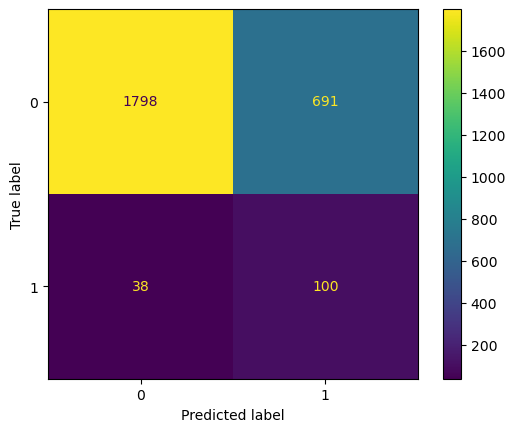

In [30]:
check_performance(best_model, X_test, y_test)

In [31]:
threshold = []
roc_auc_score_ = []

for p in np.linspace(0,1,101):
  threshold.append(p)
  y_pred = (best_model.predict_proba(X_train)[:,1] >= p).astype(int)
  roc_auc_score_.append(roc_auc_score(y_train, y_pred))

threshold_max = threshold[np.argmax(roc_auc_score_)]

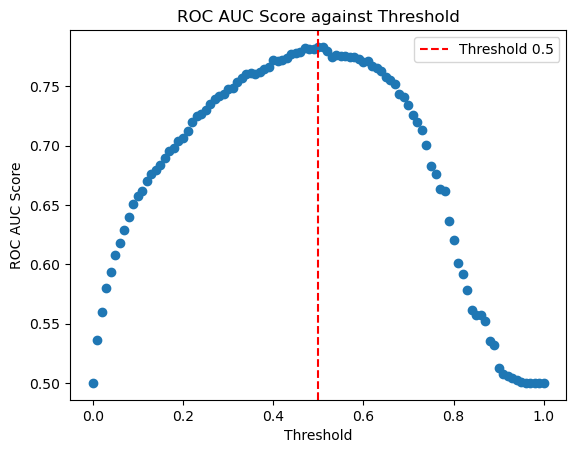

In [32]:
plt.scatter(threshold,roc_auc_score_)
plt.axvline(x=threshold_max, linestyle='--', c='red', label=f'Threshold {threshold_max}')
plt.xlabel("Threshold")
plt.ylabel("ROC AUC Score")
plt.title("ROC AUC Score against Threshold")
plt.legend(loc='best')
plt.show();

              precision    recall  f1-score   support

           0       0.98      0.72      0.83      2489
           1       0.13      0.72      0.22       138

    accuracy                           0.72      2627
   macro avg       0.55      0.72      0.52      2627
weighted avg       0.93      0.72      0.80      2627



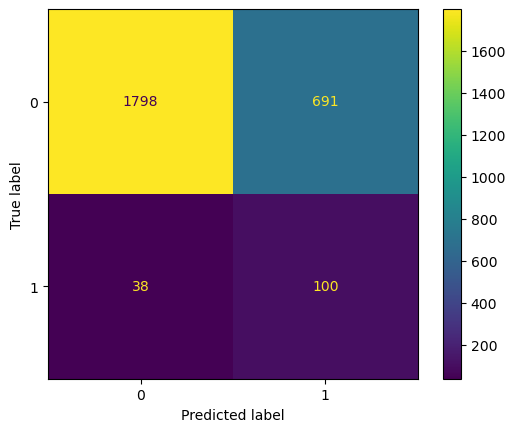

In [33]:
check_performance(best_model, X_test, y_test, threshold_max)

In [34]:
# y_hat = pd.Series(np.where(best_model.predict_proba(X_test)[:,1] >= threshold_max, 1, 0), 
#                      dtype='category')
# cm_disp_yhat = ConfusionMatrixDisplay.from_predictions(y_test, y_hat)

In [35]:
best_model.fit(X, y)

Pipeline(steps=[('col_transform',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('OneHotEncoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='infrequent_if_exist'),
                                                  ['Trap', 'Month', 'Week'])])),
                ('scale', MinMaxScaler()), ('pca', PCA(n_components=94)),
                ('sample', SMOTETomek(n_jobs=2, random_state=42)),
                ('clf',
                 LogisticRegression(C=0.1, random_state=42,
                                    solver='liblinear'))])

## Predictions

Using the best model, we'll now predict the results for the `test.csv`.

In [36]:
# Load test dataset

df_test = pd.read_csv('../assets/df_merge_test.csv', parse_dates=['Date', 'Sunrise_1', 'Sunset_1'])

In [37]:
# Apply same changes to the test dataset

df_test = create_dt_features(df_test)

In [39]:
# submission_predictions = best_model.predict(df_test[features])

# submission_predictions = pd.Series(np.where(best_model.predict_proba(df_test[features])[:,1] >= threshold_max, 1, 0), 
#                      dtype='category')

submission_predictions = pd.Series(np.where(best_model.predict_proba(df_test.drop(columns=['Date', 'Sunrise_1', 'Sunset_1', 'daylight_duration']))[:,1] >= threshold_max, 1, 0), 
                     dtype='category')

In [40]:
# Create function to execute model for predictions

def create_predictions(predictions, filename):
    if not os.path.isdir('../output'):
        os.mkdir('../output')
    
    if not os.path.isfile(f'../output/{filename}.csv'):
        results_df = pd.DataFrame(predictions)
        results_df.insert(0, column='id', value=range(1, len(predictions)+1))
        results_df.to_csv(f"../output/{filename}.csv", header=["Id", "WnvPresent"], index=False)
    else:
        raise NameError(f'{filename}.csv already exists!')

In [41]:
output_filename = 'predictions_38'

create_predictions(submission_predictions, output_filename)

In [42]:
# results.display().to_csv(f'../output/params_{output_filename}.csv', index=False)

With our best performing model, we have performed predictions on an entirely unseen dataset made available through Kaggle.

With the trained model, we will now look into the cost benefit analysis of our targetted spray strategy and present our recommendations in the next [part](Part_4_WNV_CBA_Conclusion.ipynb).